In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=1000)
X_train = faces['images']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
width, height = 32, 32
X_train = tf.image.resize(X_train[..., np.newaxis], (width, height))

In [ ]:
nb_epochs = 20
batch_size = 50
code_length = 256

In [ ]:
def add_noise(images, noise_factor=0.2):
    noisy_images = images + noise_factor * tf.random.normal(shape=images.shape)
    return tf.clip_by_value(noisy_images, 0.0, 1.0)

In [ ]:
def build_autoencoder(input_shape, code_length=256):
    input_img = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_img)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    code_layer = layers.Dense(code_length, activation='sigmoid')(x)

    x = layers.Dense((width // 2) * (height // 2) * 128, activation='relu')(code_layer)
    x = layers.Reshape((width // 2, height // 2, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    output_img = layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, output_img)
    return autoencoder


In [ ]:
input_shape = (width, height, 1)
autoencoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
X_train_noisy = add_noise(X_train)
autoencoder.fit(X_train_noisy, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0263
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.0213
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0200
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0195
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0182
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0180
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0178
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0168
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0157
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0151
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0148
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0138
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0131
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0121
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0121
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


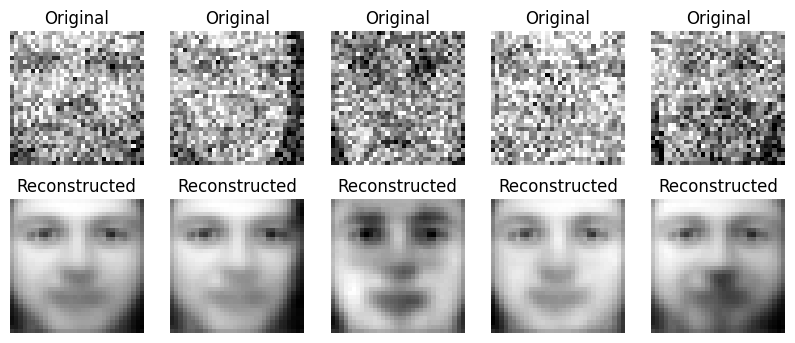

In [ ]:
def show_images(original, reconstructed, num=5):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num, num + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.show()

X_train_noisy = X_train_noisy.numpy() if isinstance(X_train_noisy, tf.Tensor) else X_train_noisy

reconstructed_images = autoencoder.predict(X_train_noisy[:5])
show_images(X_train_noisy, reconstructed_images)

In [ ]:
import numpy as np

# Get the encoder and decoder layers (adjust indices based on your model structure)
encoder_layers = [layer for layer in autoencoder.layers if isinstance(layer, (layers.Conv2D, layers.Dense)) and not isinstance(layer, layers.Conv2DTranspose)]
decoder_layers = [layer for layer in autoencoder.layers if isinstance(layer, (layers.Conv2DTranspose, layers.Dense)) and not isinstance(layer, layers.Conv2D)]

# Save encoder weights and biases
for i, layer in enumerate(encoder_layers):
    weights = layer.get_weights()
    np.savetxt(f'encoder_layer_{i}_weights.txt', weights[0].flatten())
    if len(weights) > 1:
        np.savetxt(f'encoder_layer_{i}_biases.txt', weights[1].flatten())

# Save decoder weights and biases
for i, layer in enumerate(decoder_layers):
    weights = layer.get_weights()
    np.savetxt(f'decoder_layer_{i}_weights.txt', weights[0].flatten())
    if len(weights) > 1:
        np.savetxt(f'decoder_layer_{i}_biases.txt', weights[1].flatten())

# Save one input image
one_input_image = X_train_noisy[0]
np.savetxt('input_image_pixels.txt', one_input_image.flatten())

print("Encoder weights, decoder weights, and input image pixel values saved to text files.")

Encoder weights, decoder weights, and input image pixel values saved to text files.


In [ ]:
import numpy as np

# Specify the file you want to convert
input_filename = 'encoder_layer_0_weights.txt'
output_filename = 'encoder_layer_0_weights_binary_separated.txt'

# Read the floating-point values
float_values = np.loadtxt(input_filename)

# Convert to 8-bit integers (assuming values are between 0 and 1)
int_values = (float_values * 255).astype(np.uint8)

# Convert each integer to an 8-bit binary string
binary_strings = [f'{val:08b}' for val in int_values]

# Save each binary string to a new line in the text file
with open(output_filename, 'w') as f:
    for binary_str in binary_strings:
        f.write(binary_str + '\n')

print(f"Converted {input_filename} to 8-bit binary, one per line, in {output_filename}")

Converted encoder_layer_0_weights.txt to 8-bit binary, one per line, in encoder_layer_0_weights_binary_separated.txt
